In [1]:
import os
import configparser

# Loading configurations
configParser = configparser.RawConfigParser()   
configFilePath = r'configuration.txt'
configParser.read(configFilePath)

insert_amd_env_vars =  int(configParser.get('COMMON', 'insert_amd_env_vars'))
HSA_OVERRIDE_GFX_VERSION =  configParser.get('COMMON', 'HSA_OVERRIDE_GFX_VERSION')
ROCM_PATH =  configParser.get('COMMON', 'ROCM_PATH')

if(insert_amd_env_vars != 0):
    os.environ["HSA_OVERRIDE_GFX_VERSION"] = HSA_OVERRIDE_GFX_VERSION
    os.environ["ROCM_PATH"] = ROCM_PATH
    
#import os
#os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
#os.environ["AUTOGRAPH_VERBOSITY"] = "0"

In [2]:

import configparser

# Loading configurations
configParser = configparser.RawConfigParser()   
configFilePath = r'configuration.txt'
configParser.read(configFilePath)


datasetPathGeneratedFaces =  configParser.get('evaluate_imagen', 'test_datasetPathGeneratedFaces')
generated_face_table_name =  configParser.get('evaluate_imagen', 'generated_face_table_name')
evaluation_results_folder = configParser.get('evaluate_imagen', 'evaluation_results_folder')
datasetPathFaces =  configParser.get('evaluate_imagen', 'test_datasetpathfaces')

datasetPathGeneratedFaces_pooled =  configParser.get('evaluate_imagen', 'test_datasetpathgeneratedfaces_pooled')
datasetPathFaces_pooled =  configParser.get('evaluate_imagen', 'test_datasetpathfaces_pooled')

datasetPathDatabase =  configParser.get('COMMON', 'test_datasetPathDatabase') + '/dataset.db'


cuda =  int(configParser.get('COMMON', 'cuda'))
cpus =  int(configParser.get('COMMON', 'cpus'))




In [3]:
#TODO document jupyter
import pickle
import sqlite3 as sl
import pandas as pd
import numpy as np
from PIL import Image

from textwrap import wrap
import os


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



In [4]:
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None


In [5]:
image_size =  int(configParser.get('COMMON', 'resizeImageTo'))
audio_length_used =  configParser.get('evaluate_imagen', 'audio_length_used') 
model_filename =  configParser.get('evaluate_imagen', 'model_filename') + '_'  + audio_length_used +  's.pt'
openl3_mode =  configParser.get('evaluate_imagen', 'openl3_mode')

In [6]:
import lancedb
uri = datasetPathDatabase
db = lancedb.connect(uri)

table_generated = db.open_table(generated_face_table_name).to_pandas()
#table_generated = table_generated.loc[table_generated.index.repeat(5)].reset_index(drop=True)
table_generated


,id,id_true,generated_face_path,user
0,0,0,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00017
1,1,1,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00061
2,2,2,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00081
3,3,3,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00154
4,4,4,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00419
...,...,...,...,...
113,113,113,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08552
114,114,114,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08696
115,115,115,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08701
116,116,116,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08911


In [7]:
import multiprocessing
try:
    multiprocessing.set_start_method('spawn')
except:
    print("")

In [8]:
audio_folder = output_folder = r'imagen_testing_folder' 
if not os.path.exists(audio_folder):
    os.makedirs(audio_folder)

In [9]:
from testing_imagen_face import extract_face_attr_and_rep
table_generated['face_path'] = table_generated['generated_face_path']
proc = multiprocessing.Process(target=extract_face_attr_and_rep, args=(table_generated,output_folder,))
proc.start()
proc.join()

2023-11-07 13:09:08.972513: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 13:09:09.042253: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Action: race: 100%|██████████| 3/3 [00:00<00:00, 18.23it/s]  


In [10]:
with open(output_folder + '/' + 'df_data_100.pickle', 'rb') as handle:
    table_generated = pickle.load(handle)
table_generated = table_generated.drop('face_path', axis=1)
table_generated

,id,id_true,generated_face_path,user,gender,ethnicity,age,face_rep
0,0,0,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00017,Man,white,33,"[0.008785290643572807, 0.001880174269899726, 0..."
1,1,1,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00061,Man,white,32,"[0.027697086334228516, 0.0013938553165644407, ..."
2,2,2,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00081,Man,white,24,"[0.03125414252281189, 0.006610211916267872, 0...."
3,3,3,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00154,Man,asian,22,"[0.016511332243680954, 0.011852320283651352, 0..."
4,4,4,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00419,Woman,white,38,"[0.005311249755322933, 0.0003412113292142749, ..."
...,...,...,...,...,...,...,...,...
113,113,113,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08552,Man,black,30,"[0.013793964870274067, 0.01106172613799572, 0...."
114,114,114,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08696,Man,black,26,"[0.011646328493952751, 0.00013926136307418346,..."
115,115,115,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08701,Man,white,45,"[0.026268649846315384, -0.004474387504160404, ..."
116,116,116,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08911,Man,white,34,"[0.014532344415783882, 0.0034088422544300556, ..."


In [11]:
import shutil
import sys
import time


try:
    db.drop_table('matches')
except:
    pass

i = 0
len_gen_tbl = len(table_generated)
for index, row in table_generated.iterrows():

    face_file = row['generated_face_path']
    user = row['user']
    id_true= int(row['id_true'])
    face_rep = row['face_rep']
    gender = row['gender']
    ethnicity = row['ethnicity']
    age = int(row['age'])


    tbl = db.open_table("video_stage1")
    result = tbl.search(row['face_rep']).limit(10).to_df()

    match_1 = result.iloc[0]['user']
    match_2 = result.iloc[1]['user']
    match_3 = result.iloc[2]['user']
    match_4 = result.iloc[3]['user']
    match_5 = result.iloc[4]['user']
    match_6 = result.iloc[5]['user']
    match_7 = result.iloc[6]['user']
    match_8 = result.iloc[7]['user']
    match_9 = result.iloc[8]['user']
    match_10= result.iloc[9]['user']


    df_table = pd.DataFrame()
    df_table = df_table.append({'id': i , 'id_true':id_true,
                    'generated_face_path': face_file,'user':user,'age':age,'gender':gender,'ethnicity':ethnicity,
                    'match_1':match_1,'match_2':match_2,'match_3':match_3,'match_4':match_4,'match_5':match_5,
                    'match_6':match_6,'match_7':match_7,'match_8':match_8,'match_9':match_9,'match_10':match_10,
        'vector' : face_rep,'stage': 1}, ignore_index=True)
    


    try:
        matches_tbl.add(df_table)
    except:
        matches_tbl = db.create_table('matches', df_table)

    i = i + 1
    sys.stdout.write("\r%d%%" % int(i/len_gen_tbl * 100) )
    sys.stdout.flush()




1%

100%

In [12]:
matches_pd = matches_tbl.to_pandas()
matches_pd

,id,id_true,generated_face_path,user,age,gender,ethnicity,match_1,match_2,match_3,match_4,match_5,match_6,match_7,match_8,match_9,match_10,vector,stage
0,0,0,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00017,33,Man,white,id01041,id08701,id07874,id07868,id04232,id04094,id01106,id02685,id03862,id02577,"[0.008785291, 0.0018801743, 0.00052681693, 0.0...",1
1,1,1,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00061,32,Man,white,id07961,id00562,id06913,id03839,id02745,id00017,id02576,id07426,id04295,id02286,"[0.027697086, 0.0013938553, 0.026372235, 0.001...",1
2,2,2,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00081,24,Man,white,id01066,id00562,id05816,id07396,id04295,id03677,id03862,id07354,id06104,id01509,"[0.031254143, 0.006610212, 0.012394503, 0.0150...",1
3,3,3,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00154,22,Man,asian,id02548,id04656,id07494,id00154,id01509,id08149,id04570,id08456,id07620,id04478,"[0.016511332, 0.01185232, 0.01885447, -0.00595...",1
4,4,4,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00419,38,Woman,white,id01333,id05459,id03980,id07802,id00419,id03981,id02181,id04627,id04950,id04030,"[0.0053112498, 0.00034121133, 0.004552627, 0.0...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,113,113,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08552,30,Man,black,id08552,id04862,id04006,id02542,id03677,id06104,id08456,id08392,id07874,id08696,"[0.013793965, 0.011061726, 0.008405287, 0.0056...",1
114,114,114,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08696,26,Man,black,id08552,id02542,id04006,id04862,id08696,id05055,id01989,id08456,id03677,id08392,"[0.0116463285, 0.00013926136, -0.0037793156, 0...",1
115,115,115,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08701,45,Man,white,id01041,id08701,id06104,id07874,id07396,id03677,id01106,id04366,id04232,id07868,"[0.02626865, -0.0044743875, 0.0040741307, 0.01...",1
116,116,116,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08911,34,Man,white,id04094,id02685,id02576,id08548,id06913,id06104,id08701,id00081,id02577,id01041,"[0.014532344, 0.0034088423, 0.0037827543, 0.01...",1


In [13]:
ptable_unique_users = matches_pd.drop_duplicates(subset=['user'], keep='first')
unique_users = ptable_unique_users['user'].to_numpy()
unique_users

array(['id00017', 'id00061', 'id00081', 'id00154', 'id00419', 'id00562',
       'id00812', 'id00817', 'id00866', 'id00926', 'id01000', 'id01041',
       'id01066', 'id01106', 'id01224', 'id01228', 'id01298', 'id01333',
       'id01437', 'id01460', 'id01509', 'id01541', 'id01567', 'id01593',
       'id01618', 'id01822', 'id01892', 'id01989', 'id02019', 'id02057',
       'id02086', 'id02181', 'id02286', 'id02317', 'id02445', 'id02465',
       'id02542', 'id02548', 'id02576', 'id02577', 'id02685', 'id02725',
       'id02745', 'id03030', 'id03041', 'id03127', 'id03178', 'id03347',
       'id03382', 'id03524', 'id03677', 'id03789', 'id03839', 'id03862',
       'id03969', 'id03978', 'id03980', 'id03981', 'id04006', 'id04030',
       'id04094', 'id04119', 'id04232', 'id04253', 'id04276', 'id04295',
       'id04366', 'id04478', 'id04536', 'id04570', 'id04627', 'id04656',
       'id04657', 'id04862', 'id04950', 'id05015', 'id05055', 'id05124',
       'id05176', 'id05202', 'id05459', 'id05594', 

In [14]:
pd_generated = db.open_table('matches').to_pandas()
pd_generated

,id,id_true,generated_face_path,user,age,gender,ethnicity,match_1,match_2,match_3,match_4,match_5,match_6,match_7,match_8,match_9,match_10,vector,stage
0,0,0,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00017,33,Man,white,id01041,id08701,id07874,id07868,id04232,id04094,id01106,id02685,id03862,id02577,"[0.008785291, 0.0018801743, 0.00052681693, 0.0...",1
1,1,1,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00061,32,Man,white,id07961,id00562,id06913,id03839,id02745,id00017,id02576,id07426,id04295,id02286,"[0.027697086, 0.0013938553, 0.026372235, 0.001...",1
2,2,2,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00081,24,Man,white,id01066,id00562,id05816,id07396,id04295,id03677,id03862,id07354,id06104,id01509,"[0.031254143, 0.006610212, 0.012394503, 0.0150...",1
3,3,3,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00154,22,Man,asian,id02548,id04656,id07494,id00154,id01509,id08149,id04570,id08456,id07620,id04478,"[0.016511332, 0.01185232, 0.01885447, -0.00595...",1
4,4,4,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00419,38,Woman,white,id01333,id05459,id03980,id07802,id00419,id03981,id02181,id04627,id04950,id04030,"[0.0053112498, 0.00034121133, 0.004552627, 0.0...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,113,113,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08552,30,Man,black,id08552,id04862,id04006,id02542,id03677,id06104,id08456,id08392,id07874,id08696,"[0.013793965, 0.011061726, 0.008405287, 0.0056...",1
114,114,114,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08696,26,Man,black,id08552,id02542,id04006,id04862,id08696,id05055,id01989,id08456,id03677,id08392,"[0.0116463285, 0.00013926136, -0.0037793156, 0...",1
115,115,115,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08701,45,Man,white,id01041,id08701,id06104,id07874,id07396,id03677,id01106,id04366,id04232,id07868,"[0.02626865, -0.0044743875, 0.0040741307, 0.01...",1
116,116,116,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08911,34,Man,white,id04094,id02685,id02576,id08548,id06913,id06104,id08701,id00081,id02577,id01041,"[0.014532344, 0.0034088423, 0.0037827543, 0.01...",1


In [15]:
pd_truth = db.open_table("video_stage1").to_pandas()
pd_truth

,id,video_path,face_path,user,blurred_face_path,features_path,age,gender,ethnicity,vector,stage
0,0,/media/gamal/Passport/Datasets/Voxceleb2TestVi...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00017,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,26,Man,white,"[0.025988284, 0.002286622, 0.0059057563, 0.008...",1
1,1,/media/gamal/Passport/Datasets/Voxceleb2TestVi...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00061,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,31,Man,white,"[0.014909588, 0.01032118, 0.023922412, 0.00729...",1
2,2,/media/gamal/Passport/Datasets/Voxceleb2TestVi...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00081,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,28,Man,latino hispanic,"[0.017716583, 0.031231219, 0.0167601, 0.001974...",1
3,3,/media/gamal/Passport/Datasets/Voxceleb2TestVi...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00154,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,29,Man,middle eastern,"[0.015032666, 0.0020783008, 0.0017736976, -0.0...",1
4,4,/media/gamal/Passport/Datasets/Voxceleb2TestVi...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00419,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,38,Woman,white,"[0.014704544, -0.0042701024, 0.00066350354, 0....",1
...,...,...,...,...,...,...,...,...,...,...,...
113,113,/media/gamal/Passport/Datasets/Voxceleb2TestVi...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08552,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,26,Man,black,"[0.011644645, 0.006384785, 0.0013400487, 0.009...",1
114,114,/media/gamal/Passport/Datasets/Voxceleb2TestVi...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08696,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,27,Man,black,"[0.01209747, 0.011594199, 0.018551253, 0.01129...",1
115,115,/media/gamal/Passport/Datasets/Voxceleb2TestVi...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08701,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,44,Man,white,"[0.020973165, -0.011326933, -0.0015938727, 0.0...",1
116,116,/media/gamal/Passport/Datasets/Voxceleb2TestVi...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08911,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,26,Man,white,"[0.027417418, -0.0014938384, 0.011837885, 0.00...",1


In [16]:
f= open(evaluation_results_folder + "/results.txt","w+")
f.write("No. of generated faces: " + str(len(table_generated)) + "\n")
f.write("No. of unique users: " + str(len(ptable_unique_users)) + "\n")
f.flush()

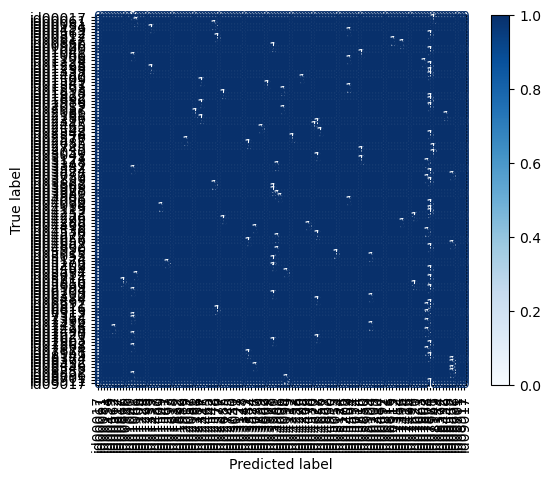

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

display_labels = unique_users
cm = confusion_matrix(pd_generated['user'],pd_generated['match_1'],labels=display_labels)
prfs = precision_recall_fscore_support(pd_generated['user'], pd_generated['match_1'], average='micro',labels=display_labels)
acc = accuracy_score(pd_generated['user'], pd_generated['match_1'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels,)
disp.plot(cmap="Blues",xticks_rotation=90)
disp.figure_.savefig(evaluation_results_folder + "/face_recog_1.png",dpi=300,)

f.write("\n" + "Face Recognition while considering the first 1 match:" + "\n")
f.write("Accuracy: " + str(acc) + "\n")
f.write("Precision: " + str(prfs[0]) + "\n")
f.write("Recall: " + str(prfs[1]) + "\n")
f.write("F1-score: " + str(prfs[2]) + "\n")
f.flush()

In [18]:
from collections import Counter

def Most_Common(lst):
    data = Counter(lst)
    return data.most_common(1)[0][0]

def face_recog_first_n_matches(row,n):
    #print(n == 3)

    user = row['user']
    match_1 = row['match_1']
    match_2 = row['match_2']
    match_3 = row['match_3']
    match_4 = row['match_4']
    match_5 = row['match_5']
    match_6 = row['match_6']
    match_7 = row['match_7']
    match_8 = row['match_8']
    match_9 = row['match_9']
    match_10 = row['match_10']
    if(n==3):
        if(user == match_1 or user == match_2 or user == match_3):
            row['match_n_3'] = user
        else:
            lst = [match_1,match_2,match_3]
            row['match_n_3'] = Most_Common(lst)
    elif(n==5):
        if(user == match_1 or user == match_2 or user == match_3 or user == match_4 or user == match_5):
            row['match_n_5'] = user
        else:
            lst = [match_1,match_2,match_3,match_4,match_5]
            row['match_n_5'] = Most_Common(lst)
    elif(n==10):
        if(user == match_1 or user == match_2 or user == match_3 or user == match_4 or user == match_5 or
           user == match_6 or user == match_7 or user == match_8 or user == match_9 or user == match_10):
            row['match_n_10'] = user
        else:
            lst = [match_1,match_2,match_3,match_4,match_5,match_6,match_7,match_8,match_9,match_10]
            row['match_n_10'] = Most_Common(lst)
    else:
        raise Exception("n can only be 3,5 or 10") 
    
    #print(row)
    return row

In [19]:
pd_generated = db.open_table('matches').to_pandas()
pd_generated = pd_generated.apply(face_recog_first_n_matches,args=(3,),axis=1)
pd_generated = pd_generated.apply(face_recog_first_n_matches,args=(5,),axis=1)
pd_generated = pd_generated.apply(face_recog_first_n_matches,args=(10,),axis=1)
pd_generated

,id,id_true,generated_face_path,user,age,gender,ethnicity,match_1,match_2,match_3,match_4,match_5,match_6,match_7,match_8,match_9,match_10,vector,stage,match_n_3,match_n_5,match_n_10
0,0,0,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00017,33,Man,white,id01041,id08701,id07874,id07868,id04232,id04094,id01106,id02685,id03862,id02577,"[0.008785291, 0.0018801743, 0.00052681693, 0.0...",1,id01041,id01041,id01041
1,1,1,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00061,32,Man,white,id07961,id00562,id06913,id03839,id02745,id00017,id02576,id07426,id04295,id02286,"[0.027697086, 0.0013938553, 0.026372235, 0.001...",1,id07961,id07961,id07961
2,2,2,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00081,24,Man,white,id01066,id00562,id05816,id07396,id04295,id03677,id03862,id07354,id06104,id01509,"[0.031254143, 0.006610212, 0.012394503, 0.0150...",1,id01066,id01066,id01066
3,3,3,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00154,22,Man,asian,id02548,id04656,id07494,id00154,id01509,id08149,id04570,id08456,id07620,id04478,"[0.016511332, 0.01185232, 0.01885447, -0.00595...",1,id02548,id00154,id00154
4,4,4,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00419,38,Woman,white,id01333,id05459,id03980,id07802,id00419,id03981,id02181,id04627,id04950,id04030,"[0.0053112498, 0.00034121133, 0.004552627, 0.0...",1,id01333,id00419,id00419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,113,113,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08552,30,Man,black,id08552,id04862,id04006,id02542,id03677,id06104,id08456,id08392,id07874,id08696,"[0.013793965, 0.011061726, 0.008405287, 0.0056...",1,id08552,id08552,id08552
114,114,114,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08696,26,Man,black,id08552,id02542,id04006,id04862,id08696,id05055,id01989,id08456,id03677,id08392,"[0.0116463285, 0.00013926136, -0.0037793156, 0...",1,id08552,id08696,id08696
115,115,115,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08701,45,Man,white,id01041,id08701,id06104,id07874,id07396,id03677,id01106,id04366,id04232,id07868,"[0.02626865, -0.0044743875, 0.0040741307, 0.01...",1,id08701,id08701,id08701
116,116,116,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08911,34,Man,white,id04094,id02685,id02576,id08548,id06913,id06104,id08701,id00081,id02577,id01041,"[0.014532344, 0.0034088423, 0.0037827543, 0.01...",1,id04094,id04094,id04094


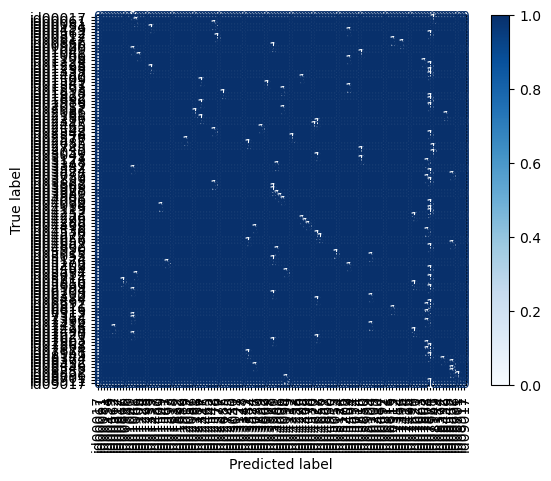

In [20]:

display_labels = unique_users
cm = confusion_matrix(pd_generated['user'],pd_generated['match_n_3'],labels=display_labels)
prfs = precision_recall_fscore_support(pd_generated['user'], pd_generated['match_n_3'], average='micro',labels=display_labels)
acc = accuracy_score(pd_generated['user'], pd_generated['match_n_3'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels,)
disp.plot(cmap="Blues",xticks_rotation=90)
disp.figure_.savefig(evaluation_results_folder + "/face_recog_3.png",dpi=300,)

f.write("\n" + "Face Recognition while considering the first 3 matches:" + "\n")
f.write("Accuracy: " + str(acc) + "\n")
f.write("Precision: " + str(prfs[0]) + "\n")
f.write("Recall: " + str(prfs[1]) + "\n")
f.write("F1-score: " + str(prfs[2]) + "\n")
f.flush()

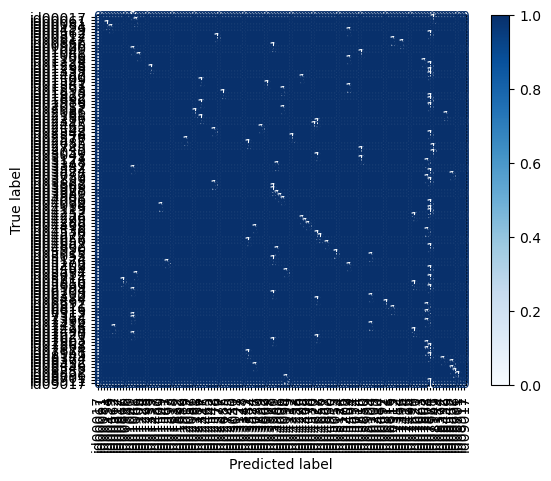

In [21]:

display_labels = unique_users
cm = confusion_matrix(pd_generated['user'],pd_generated['match_n_5'],labels=display_labels)
prfs = precision_recall_fscore_support(pd_generated['user'], pd_generated['match_n_5'], average='micro',labels=display_labels)
acc = accuracy_score(pd_generated['user'], pd_generated['match_n_5'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels,)
disp.plot(cmap="Blues",xticks_rotation=90)
disp.figure_.savefig(evaluation_results_folder + "/face_recog_5.png",dpi=300,)

f.write("\n" + "Face Recognition while considering the first 5 matches:" + "\n")
f.write("Accuracy: " + str(acc) + "\n")
f.write("Precision: " + str(prfs[0]) + "\n")
f.write("Recall: " + str(prfs[1]) + "\n")
f.write("F1-score: " + str(prfs[2]) + "\n")
f.flush()

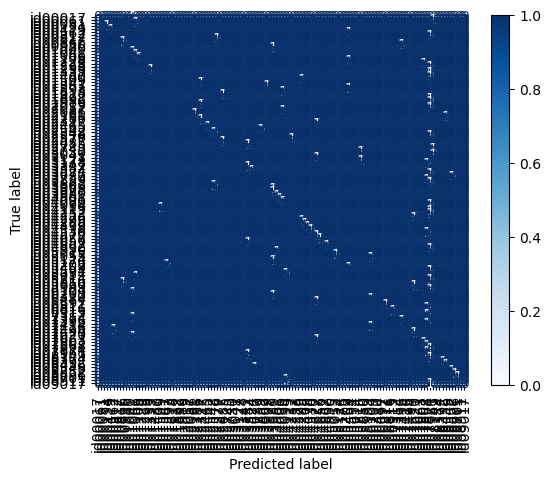

In [22]:

display_labels = unique_users
cm = confusion_matrix(pd_generated['user'],pd_generated['match_n_10'],labels=display_labels)
prfs = precision_recall_fscore_support(pd_generated['user'], pd_generated['match_n_10'], average='micro',labels=display_labels)
acc = accuracy_score(pd_generated['user'], pd_generated['match_n_10'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels,)
disp.plot(cmap="Blues",xticks_rotation=90)
disp.figure_.savefig(evaluation_results_folder + "/face_recog_10.png",dpi=300,)

f.write("\n" + "Face Recognition while considering the first 10 matches:" + "\n")
f.write("Accuracy: " + str(acc) + "\n")
f.write("Precision: " + str(prfs[0]) + "\n")
f.write("Recall: " + str(prfs[1]) + "\n")
f.write("F1-score: " + str(prfs[2]) + "\n")
f.flush()

In [23]:
pd_joined = pd.merge(pd_generated, pd_truth, left_on="id_true",right_on="id",suffixes=("_gen", "_true"))
pd_joined

,id_gen,id_true,generated_face_path,user_gen,age_gen,gender_gen,ethnicity_gen,match_1,match_2,match_3,match_4,match_5,match_6,match_7,match_8,match_9,match_10,vector_gen,stage_gen,match_n_3,match_n_5,match_n_10,id_true,video_path,face_path,user_true,blurred_face_path,features_path,age_true,gender_true,ethnicity_true,vector_true,stage_true
0,0,0,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00017,33,Man,white,id01041,id08701,id07874,id07868,id04232,id04094,id01106,id02685,id03862,id02577,"[0.008785291, 0.0018801743, 0.00052681693, 0.0...",1,id01041,id01041,id01041,0,/media/gamal/Passport/Datasets/Voxceleb2TestVi...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00017,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,26,Man,white,"[0.025988284, 0.002286622, 0.0059057563, 0.008...",1
1,1,1,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00061,32,Man,white,id07961,id00562,id06913,id03839,id02745,id00017,id02576,id07426,id04295,id02286,"[0.027697086, 0.0013938553, 0.026372235, 0.001...",1,id07961,id07961,id07961,1,/media/gamal/Passport/Datasets/Voxceleb2TestVi...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00061,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,31,Man,white,"[0.014909588, 0.01032118, 0.023922412, 0.00729...",1
2,2,2,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00081,24,Man,white,id01066,id00562,id05816,id07396,id04295,id03677,id03862,id07354,id06104,id01509,"[0.031254143, 0.006610212, 0.012394503, 0.0150...",1,id01066,id01066,id01066,2,/media/gamal/Passport/Datasets/Voxceleb2TestVi...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00081,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,28,Man,latino hispanic,"[0.017716583, 0.031231219, 0.0167601, 0.001974...",1
3,3,3,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00154,22,Man,asian,id02548,id04656,id07494,id00154,id01509,id08149,id04570,id08456,id07620,id04478,"[0.016511332, 0.01185232, 0.01885447, -0.00595...",1,id02548,id00154,id00154,3,/media/gamal/Passport/Datasets/Voxceleb2TestVi...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00154,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,29,Man,middle eastern,"[0.015032666, 0.0020783008, 0.0017736976, -0.0...",1
4,4,4,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00419,38,Woman,white,id01333,id05459,id03980,id07802,id00419,id03981,id02181,id04627,id04950,id04030,"[0.0053112498, 0.00034121133, 0.004552627, 0.0...",1,id01333,id00419,id00419,4,/media/gamal/Passport/Datasets/Voxceleb2TestVi...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00419,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,38,Woman,white,"[0.014704544, -0.0042701024, 0.00066350354, 0....",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,113,113,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08552,30,Man,black,id08552,id04862,id04006,id02542,id03677,id06104,id08456,id08392,id07874,id08696,"[0.013793965, 0.011061726, 0.008405287, 0.0056...",1,id08552,id08552,id08552,113,/media/gamal/Passport/Datasets/Voxceleb2TestVi...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08552,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,26,Man,black,"[0.011644645, 0.006384785, 0.0013400487, 0.009...",1
114,114,114,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08696,26,Man,black,id08552,id02542,id04006,id04862,id08696,id05055,id01989,id08456,id03677,id08392,"[0.0116463285, 0.00013926136, -0.0037793156, 0...",1,id08552,id08696,id08696,114,/media/gamal/Passport/Datasets/Voxceleb2TestVi...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08696,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,/media/gamal/Pass

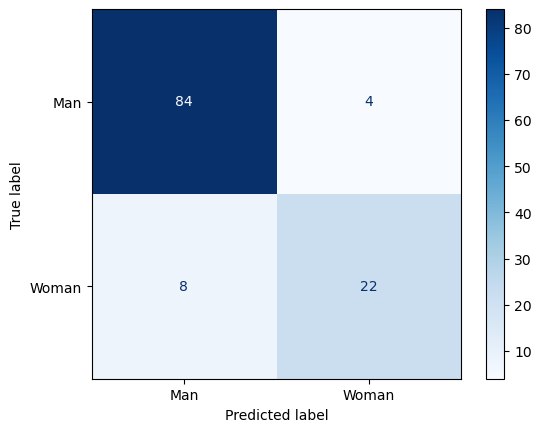

In [24]:
display_labels = pd_joined.drop_duplicates(subset=['gender_true'], keep='first')['gender_true']
cm = confusion_matrix(pd_joined['gender_true'], pd_joined['gender_gen'],labels=display_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels,)
disp.plot(cmap="Blues")
disp.figure_.savefig(evaluation_results_folder + "/gender_cm.png",dpi=300)

prfs = precision_recall_fscore_support(pd_joined['gender_true'], pd_joined['gender_gen'], average='micro',labels=display_labels)
acc = accuracy_score(pd_joined['gender_true'], pd_joined['gender_gen'])
f.write("\n" + "Gender:" + "\n")
f.write("Accuracy: " + str(acc) + "\n")
f.write("Precision: " + str(prfs[0]) + "\n")
f.write("Recall: " + str(prfs[1]) + "\n")
f.write("F1-score: " + str(prfs[2]) + "\n")
f.flush()

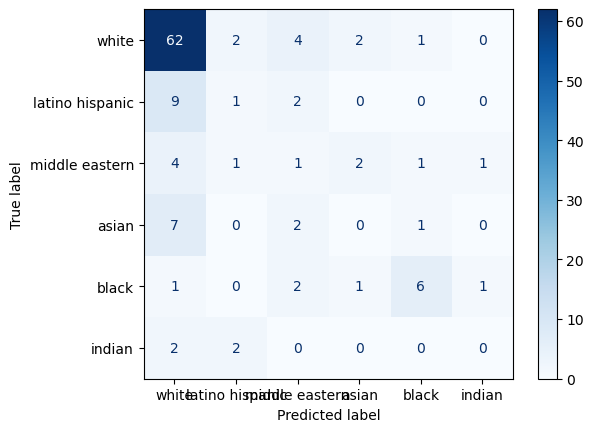

In [25]:
display_labels = pd_joined.drop_duplicates(subset=['ethnicity_true'], keep='first')['ethnicity_true']
cm = confusion_matrix(pd_joined['ethnicity_true'], pd_joined['ethnicity_gen'],labels=display_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels,)
disp.plot(cmap="Blues",xticks_rotation=90)
disp.figure_.savefig(evaluation_results_folder + "/ethnicity_cm.png",dpi=300)

prfs = precision_recall_fscore_support(pd_joined['ethnicity_true'], pd_joined['ethnicity_gen'], average='micro',labels=display_labels)
acc = accuracy_score(pd_joined['ethnicity_true'], pd_joined['ethnicity_gen'])
f.write("\n" + "Ethnicity:" + "\n")
f.write("Accuracy: " + str(acc) + "\n")
f.write("Precision: " + str(prfs[0]) + "\n")
f.write("Recall: " + str(prfs[1]) + "\n")
f.write("F1-score: " + str(prfs[2]) + "\n")
f.flush()

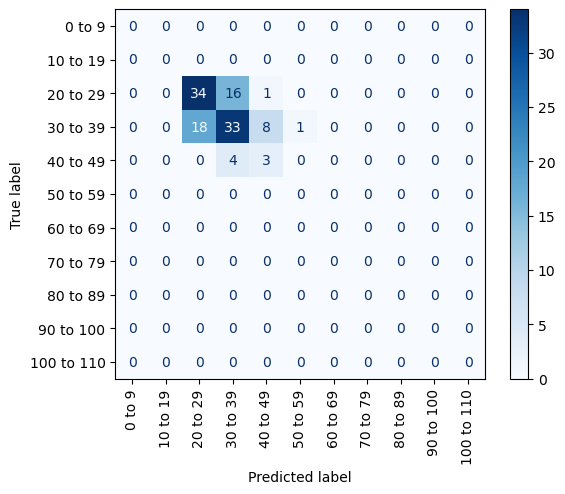

In [26]:
age_bins= [0,10,20,30,40,50,60,70,80,90,100,110]
labels = ['0 to 9','10 to 19','20 to 29','30 to 39','40 to 49','50 to 59', '60 to 69', '70 to 79', '80 to 89', '90 to 100','100 to 110']
pd_joined['age_group_gen'] = pd.cut(pd_joined['age_gen'], bins=age_bins, labels=labels, right=False)
pd_joined['age_group_true'] = pd.cut(pd_joined['age_true'], bins=age_bins, labels=labels, right=False)


display_labels = labels
cm = confusion_matrix(pd_joined['age_group_true'], pd_joined['age_group_gen'],labels=display_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels,)
disp.plot(cmap="Blues",xticks_rotation=90)
disp.figure_.savefig(evaluation_results_folder + "/ethnicity_cm.png",dpi=300)

prfs = precision_recall_fscore_support(pd_joined['age_group_true'], pd_joined['age_group_gen'], average='micro',labels=display_labels)
acc = accuracy_score(pd_joined['age_group_true'], pd_joined['age_group_gen'])
f.write("\n" + "Age Group:" + "\n")
f.write("Accuracy: " + str(acc) + "\n")
f.write("Precision: " + str(prfs[0]) + "\n")
f.write("Recall: " + str(prfs[1]) + "\n")
f.write("F1-score: " + str(prfs[2]) + "\n")
f.flush()

In [27]:
from math import sqrt
age_true = pd_joined['age_true'].to_numpy()
age_generated = pd_joined['age_gen'].to_numpy()
age_rmse = sqrt(((age_true - age_generated)**2).mean(axis = 0))
f.write('rmse of age: ' + str(age_rmse) + " years\n")
f.flush()

In [28]:
pd_joined

,id_gen,id_true,generated_face_path,user_gen,age_gen,gender_gen,ethnicity_gen,match_1,match_2,match_3,match_4,match_5,match_6,match_7,match_8,match_9,match_10,vector_gen,stage_gen,match_n_3,match_n_5,match_n_10,id_true,video_path,face_path,user_true,blurred_face_path,features_path,age_true,gender_true,ethnicity_true,vector_true,stage_true,age_group_gen,age_group_true
0,0,0,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00017,33,Man,white,id01041,id08701,id07874,id07868,id04232,id04094,id01106,id02685,id03862,id02577,"[0.008785291, 0.0018801743, 0.00052681693, 0.0...",1,id01041,id01041,id01041,0,/media/gamal/Passport/Datasets/Voxceleb2TestVi...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00017,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,26,Man,white,"[0.025988284, 0.002286622, 0.0059057563, 0.008...",1,30 to 39,20 to 29
1,1,1,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00061,32,Man,white,id07961,id00562,id06913,id03839,id02745,id00017,id02576,id07426,id04295,id02286,"[0.027697086, 0.0013938553, 0.026372235, 0.001...",1,id07961,id07961,id07961,1,/media/gamal/Passport/Datasets/Voxceleb2TestVi...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00061,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,31,Man,white,"[0.014909588, 0.01032118, 0.023922412, 0.00729...",1,30 to 39,30 to 39
2,2,2,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00081,24,Man,white,id01066,id00562,id05816,id07396,id04295,id03677,id03862,id07354,id06104,id01509,"[0.031254143, 0.006610212, 0.012394503, 0.0150...",1,id01066,id01066,id01066,2,/media/gamal/Passport/Datasets/Voxceleb2TestVi...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00081,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,28,Man,latino hispanic,"[0.017716583, 0.031231219, 0.0167601, 0.001974...",1,20 to 29,20 to 29
3,3,3,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00154,22,Man,asian,id02548,id04656,id07494,id00154,id01509,id08149,id04570,id08456,id07620,id04478,"[0.016511332, 0.01185232, 0.01885447, -0.00595...",1,id02548,id00154,id00154,3,/media/gamal/Passport/Datasets/Voxceleb2TestVi...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00154,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,29,Man,middle eastern,"[0.015032666, 0.0020783008, 0.0017736976, -0.0...",1,20 to 29,20 to 29
4,4,4,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00419,38,Woman,white,id01333,id05459,id03980,id07802,id00419,id03981,id02181,id04627,id04950,id04030,"[0.0053112498, 0.00034121133, 0.004552627, 0.0...",1,id01333,id00419,id00419,4,/media/gamal/Passport/Datasets/Voxceleb2TestVi...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id00419,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,38,Woman,white,"[0.014704544, -0.0042701024, 0.00066350354, 0....",1,30 to 39,30 to 39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,113,113,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08552,30,Man,black,id08552,id04862,id04006,id02542,id03677,id06104,id08456,id08392,id07874,id08696,"[0.013793965, 0.011061726, 0.008405287, 0.0056...",1,id08552,id08552,id08552,113,/media/gamal/Passport/Datasets/Voxceleb2TestVi...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08552,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,26,Man,black,"[0.011644645, 0.006384785, 0.0013400487, 0.009...",1,30 to 39,20 to 29
114,114,114,/media/gamal/Passport/Datasets/VoxCeleb2Test/V...,id08696,26,Man,black,id08552,id02542,id04006,id04862,id08696,id05055,id01989,id08456,id03677,id08392,"[0.0116463285, 0.00013926136, -0.0037793156, 0...",1,id08552,id08696,id08696,114,/media/gamal/Passport/Datasets

In [29]:
def process_image_path(path):
    
    image = Image.open(path).convert('RGB')

    w_s = image_size / (1+2 * 0.4)
    h_s = image_size / (1+2 * 0.4)

    #print(image.size)
    image = image.crop((0.2*w_s,0.0*h_s,1.6*w_s,1.4*h_s))
    image = image.resize((image_size,image_size))

    #print('saving')
    #image.save(str(random.random()) + '.png')
    return image


In [30]:
import cv2
from skimage.metrics import structural_similarity as calc_ssim
from skimage.metrics import mean_squared_error
psnr = []
ssim = []
mse = []
for index, row in pd_joined.iterrows():
    im_true = process_image_path(row['face_path'])
    im_true = cv2.cvtColor(np.array(im_true), cv2.COLOR_RGB2BGR)
    
    im_generated = cv2.imread(row['generated_face_path'])
    psnr.append(cv2.PSNR(im_true, im_generated))
    #print(im_true.shape)
    ssim.append(calc_ssim(im_true,im_generated,channel_axis=2))

    mse.append(mean_squared_error(im_true,im_generated))
    
f.write('\nAverage PSNR is: ' + str(np.array(psnr).mean()) + "\n")
f.write('Average SSIM is: ' + str(np.array(ssim).mean()) + "\n")
f.write('Average  MSE is: ' + str(np.array(mse).mean()) + "\n")
f.flush()

    

In [31]:
fid = ! python -m pytorch_fid {datasetPathFaces} {datasetPathGeneratedFaces}

In [32]:
fid

['',
 '100%|██████████| 3/3 [00:01<00:00,  2.04it/s]',
 '',
 '100%|██████████| 3/3 [00:00<00:00,  5.84it/s]',
 'FID:  138.30571913886536']

In [33]:
fid_value = [s for s in fid if "FID:" in s]
f.write(str(fid_value[0]) + "\n")
f.flush()

In [34]:
f.close()

In [35]:
import shutil

shutil.copyfile('configuration.txt',evaluation_results_folder + "/configuration.txt" )

'/media/gamal/Passport/Datasets/VoxCeleb2Test/configuration.txt'